In [7]:
# importing all the necessary libraries!

import os
import warnings
import json
from datetime import datetime 
import pandas as pd
import numpy as np
from math import sqrt
from numpy.random import seed
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from keras.regularizers import L1L2
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasRegressor

import mlflow
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
plt.rcParams['figure.facecolor'] = 'white'
warnings.simplefilter('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [8]:
class DataFormatting():
      
    def __init__(self):
       
        self.df_data = None
        self.df_datetime = None

    def dataset(df):

        # converting time colum from object type to datetime format
        df['date'] = pd.to_datetime(df['date'],dayfirst = True, format = '%d/%m/%Y')
        # creating a ema feature
        #df['SMA_10'] = df[['close']].rolling(10).mean().shift(1)
        #df['SMA_50'] = df[['close']].rolling(50).mean().shift(1)
        #df['SMA_200'] = df[['close']].rolling(200).mean().shift(1)
        df = df.dropna()
        # splitting the dataframe in to X and y 
        df_data = df[['close','CPI','INTEREST_RATE']] #'high','low',,'CRUDE_OIL_CLOSE','US500_CLOSE','open','EXCHANGE_RATE',
        df_datetime =df[['date']]

        return df_data, df_datetime


# Data transformation (changing data shape to model requirement)

def data_transformation(data, lags = 5, n_fut = 1):
    
    """ this function transforms dataframe to required input shape for the model.
    It required 2 input arguments:
    1. data: this will be the pandas dataframe
    2. lags: how many previous price points to be used to predict the next future value, in
    this case the default is set to 5 for 'XAUUSD' commodity"""

    # initialize lists to store the dataset
    X_data = []
    y_data = []
    
    for i in range(lags, len(data)- n_fut +1):
        X_data.append(data[i-lags: i, 0: data.shape[1]])
        y_data.append(data[i+ n_fut-1:i+n_fut,0]) # extracts close price with specific lag as price to be predicted.

    # convert the list to numpy array

    X_data = np.array(X_data)
    y_data = np.array(y_data)

    return X_data, y_data

In [9]:
lag = 1
n_fut = 1

In [5]:
import joblib
std_scaler = joblib.load('scaler_std.bin')
data = pd.read_csv('../data/macro_data/test.csv',index_col=[0]) 
# initializing DataFormatting class
data_init = DataFormatting()
df_data, df_datetime = DataFormatting.dataset(data)
print('\n')
print('Displaying top 5 rows of the dataset:')
print('\n')
print(df_data.head())
print(df_data.shape)
print(df_data.columns)
df_colnames = list(df_data.columns)
# normalize train, val and test dataset

# initialize StandartScaler()
#scaler = StandardScaler()
#std_scaler = std_scaler.fit(df_data)
data_fit_transformed = std_scaler.transform(df_data)


print('\n')
print('Displaying top 5 rows of all the scaled dataset:')
print('\n')
#print('The train dateset:','\n''\n',data_fit_transformed[0:5],'\n''\n', 'The validation dataset:','\n''\n',val_transformed[0:5],'\n''\n','The test dataset:','\n''\n',test_transformed[0:5])
print('The train dateset:','\n''\n',data_fit_transformed[0:5])

# changing shape of the data to match the model requirement!

X_data, y_data = data_transformation(data_fit_transformed, lags = lag, n_fut = n_fut)
print('\n')
print('Displaying the shape of the dataset required by the model:')
print('\n')
print(f' Input shape X:',X_data.shape, f'Input shape y:',y_data.shape)
print('\n')
#print(X_data)
print(y_data[0:5])
#setting the model file name
#model_name = 'lstm_'+ str(units)+'.h5'


train_data_X = X_data
train_data_y = y_data
print(train_data_X.shape)



Displaying top 5 rows of the dataset:


        close       CPI  INTEREST_RATE
6371  1862.84  1.102352           0.33
6372  1868.21  1.102352           0.33
6373  1881.23  1.102352           0.33
6374  1877.10  1.102352           0.83
6375  1882.61  1.102352           0.83
(62, 3)
Index(['close', 'CPI', 'INTEREST_RATE'], dtype='object')


ValueError: X has 3 features, but StandardScaler is expecting 6 features as input.

In [6]:
path_model = "../Model_Outputs/2022_11_11/final_run/model_Bilstm/model/lstm_192.h5"
model_eval = load_model(path_model, compile=False)
forecast = model_eval.predict(train_data_X)
forecast_copies = np.repeat(forecast, df_data.shape[1], axis = -1 )
y_pred_fut = std_scaler.inverse_transform(forecast_copies)[:,0]


2022-11-13 21:49:48.505991: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-13 21:49:48.506017: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-13 21:49:48.506028: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deeplearning): /proc/driver/nvidia/version does not exist
2022-11-13 21:49:48.506196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'train_data_X' is not defined

In [6]:
print(y_pred_fut)

[1843.6354 1848.6849 1860.9149 1857.1034 1862.2759 1835.2223 1820.5306
 1833.9133 1805.0105 1795.1212 1807.0228 1798.6205 1800.0199 1824.1705
 1828.1294 1834.9021 1847.0492 1834.6478 1832.2559 1834.4408 1819.7948
 1828.2152 1849.0338 1832.4358 1823.6152 1833.8296 1834.5265 1829.685
 1851.7029 1802.6772 1792.1608 1816.3711 1837.9489 1822.3379 1815.7156
 1820.2253 1805.829  1809.9757 1805.8667 1803.2871 1801.3021 1791.2004
 1793.0624 1750.9904 1726.718  1727.6807 1729.9293 1721.8942 1714.3295
 1723.3625 1698.695  1696.4006 1697.9972 1700.4535 1686.0795 1706.8162
 1715.5604 1708.1722 1705.8419 1722.1898 1742.7688]


In [7]:
data.head()

,date,open,high,low,close,tick_volume,spread,real_volume,month,year,CPI,EXCHANGE_RATE,day,INTEREST_RATE,CRUDE_OIL_CLOSE,US500_CLOSE
6371,2022-05-02,1897.82,1899.89,1854.47,1862.84,87381,0,0,5,2022,1.102352,126.06,2,0.33,105.169998,4155.379883
6372,2022-05-03,1863.53,1878.13,1850.42,1868.21,86934,0,0,5,2022,1.102352,126.06,3,0.33,102.410004,4175.479980
6373,2022-05-04,1868.06,1889.75,1861.45,1881.23,76723,0,0,5,2022,1.102352,126.06,4,0.33,107.809998,4300.169922
6374,2022-05-05,1882.26,1909.79,1872.48,1877.10,105373,0,0,5,2022,1.102352,126.06,5,0.83,108.260002,4146.870117
6375,2022-05-06,1876.59,1892.54,1866.12,1882.61,98595,0,0,5,2022,1.102352,126.06,6,0.83,109.769997,4123.339844


In [8]:
data = data.iloc[n_fut: , :] # dropping first row since lag 1 is used
data['y_pred_close'] = y_pred_fut

In [9]:
data.shape

(61, 17)

In [10]:
MAPE_pred = tf.keras.losses.MeanAbsolutePercentageError()
print("The MAPE on the test data is:",round(MAPE_pred(data['close'], data['y_pred_close']).numpy(),3),"%")

The MAPE on the test data is: 1.001 %


<AxesSubplot: xlabel='date', ylabel='close'>

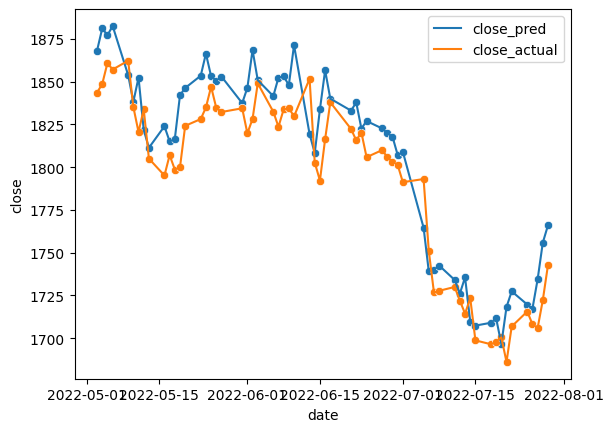

In [11]:
sns.lineplot(data = data, x  = data['date'], y = data['close'], label='close_pred')
sns.scatterplot(data = data, x  = data['date'], y = data['close'])

sns.lineplot(data = data, x = data['date'], y = data['y_pred_close'],label='close_actual')
sns.scatterplot(data = data, x = data['date'], y = data['y_pred_close'])

In [10]:
import joblib
std_scaler = joblib.load('scaler_std.bin')

In [11]:


x = np.array([[1756, 0.4, 4]]) #[1771.96, -0.011811914, 2.32],[1761, -0.011811914, 2.32],[1765, -0.011811914, 2.32]
#x = np.reshape(x, (-1,x.shape[0], x.shape[1]))
x_df = pd.DataFrame(x)
x_df


,0,1,2
0,1756.0,0.4,4.0


In [12]:
#scaler_fore = StandardScaler()
#scaler_fore = std_scaler.fit(x_df)
x_fit_transformed = std_scaler.transform(x_df)

ValueError: X has 3 features, but StandardScaler is expecting 6 features as input.

In [69]:
x_np = np.array(x_fit_transformed)
x_np = np.reshape(x_np,(-1,x_np.shape[0],x_np.shape[1]))

In [70]:
x_np.shape


(1, 1, 3)

In [71]:
forecast = model_eval.predict(x_np)
forecast_copies = np.repeat(forecast, x_np.shape[2], axis = -1 )
y_pred_fut = std_scaler.inverse_transform(forecast_copies)[:,0]


1/1 [==============================] - 0s 13ms/step


In [72]:
y_pred_fut

array([1743.1119], dtype=float32)

In [28]:
import mlflow
logged_model = './mlruns/1/39c1f23154164f219856a7c6b279a394/artifacts/model'


#mlflow.artifacts.download_artifacts(logged_model)
# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)



/home/bafna0109/.local/lib/python3.9/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [30]:
# Predict on a Pandas DataFrame.
import pandas as pd
import numpy as np
import joblib
std_scaler = joblib.load('scaler_std.bin')
x = np.array([[1706,1757,1703,1755,0.4,107.9,4,86.2,3956.74]]) #[1771.96, -0.011811914, 2.32],[1761, -0.011811914, 2.32],[1765, -0.011811914, 2.32]
#x = np.reshape(x, (-1,x.shape[0], x.shape[1]))
x_df = pd.DataFrame(x)
x_fit_transformed = std_scaler.transform(x_df)
x_np = np.array(x_fit_transformed)
x_np = np.reshape(x_np,(-1,x_np.shape[0],x_np.shape[1]))
forecast = loaded_model.predict(x_np)
forecast_copies = np.repeat(forecast, x_np.shape[2], axis = -1 )
y_pred_fut = std_scaler.inverse_transform(forecast_copies)[:,0]

y_pred_fut

/home/bafna0109/.local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 9 features, but StandardScaler is expecting 3 features as input.